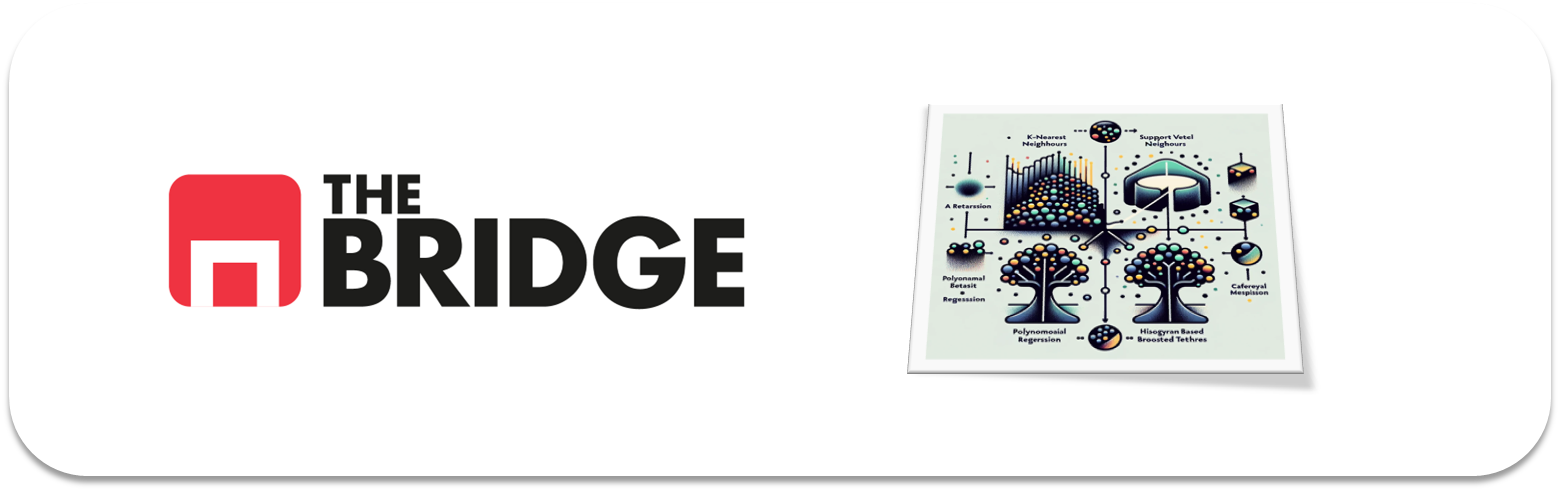

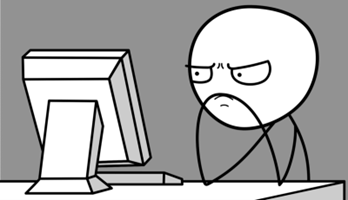

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [78]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Evitar los warning
import warnings
warnings.filterwarnings("ignore")

# Mejora características de impresión
from pprint import pprint

# Tratamiento de variables categóricas
from sklearn.preprocessing import OrdinalEncoder
pd.get_dummies # para one-hot encoding

# Tratamiento variables numéricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Separación df
from sklearn.model_selection import train_test_split

# Evaluación regresión lineal
from sklearn import linear_model, metrics, model_selection
from sklearn.model_selection import cross_val_score

# Regularización
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Evaluación regresión logística
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score,recall_score



# Entrenamiento modelos
from sklearn.linear_model import LinearRegression


# Hacer 'x' subconjuntos de 'y' elementos
from sklearn.model_selection import StratifiedShuffleSplit

# Acumular los resultados de la evaluación 'accuracy' en una lista
from sklearn.metrics import accuracy_score
# Representar el árbol de forma visual
from sklearn.tree import plot_tree

# Optimización hiperparámetros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Ensamblados

from sklearn.ensemble import RandomForestRegressor # Regresión

from sklearn.ensemble import AdaBoostRegressor # Regresión
from sklearn.ensemble import GradientBoostingRegressor # Regresión

from xgboost import XGBRFRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool


# Otros modelos supervisados

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC # "support vector classifier"
from sklearn.svm import SVR # "support vector regressor"


# Obtener todas las métrica que acepta "scoring"
from sklearn.metrics import get_scorer_names # y se pone get_scorer_names()


# Equilibrado de clases
from imblearn.over_sampling import SMOTE # Nuevos amigos para ayudaros
from imblearn.under_sampling import RandomUnderSampler # Nuevos amigos para ayudarnos
from sklearn.utils import resample


In [79]:
from toolbox_ML import *
from EDA_function_tools import *

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Lo que nos piden es un modelo que prediga con un marge de error máximo de 100 ppm (partículas por millón), por lo que debería ser el RMSE o MAE

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [80]:
df = pd.read_csv("./data/air_contamination.csv")
df.head(8)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
5,1.2,1197.00,38,4.741012,750.25,89.0,1336.50,96.0,1393.00,949.25,11.175,59.175000,0.784772
6,1.2,1185.00,31,3.624399,689.50,62.0,1461.75,77.0,1332.75,732.50,11.325,56.775000,0.760312
7,1.0,1136.25,31,3.326677,672.00,62.0,1453.25,76.0,1332.75,729.50,10.675,60.000000,0.770238


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


In [82]:
describe_df(df).T

,DATE_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
CO(GT),float64,0.0,95,1.06
PT08.S1(CO),float64,0.0,3245,36.09
NMHC(GT),int64,0.0,428,4.76
C6H6(GT),float64,0.0,3772,41.95
PT08.S2(NMHC),float64,0.0,3772,41.95
NOx(GT),float64,0.0,2362,26.27
PT08.S3(NOx),float64,0.0,3518,39.13
NO2(GT),float64,0.0,1367,15.2
PT08.S4(NO2),float64,0.0,4407,49.02
PT08.S5(O3),float64,0.0,4678,52.03


| Columna         | Cantidad no nula | Tipo    | Significado                                |
|-----------------|------------------|---------|--------------------------------------------|
| CO(GT)          | 8991             | float64 | Concentración de monóxido de carbono (CO) |
| PT08.S1(CO)     | 8991             | float64 | Sensor 1 de dióxido de carbono (CO)       |
| NMHC(GT)        | 8991             | int64   | Concentración de hidrocarburos no metánicos (NMHC) |
| C6H6(GT)        | 8991             | float64 | Concentración de benceno (C6H6)           |
| PT08.S2(NMHC)   | 8991             | float64 | Sensor 2 de hidrocarburos no metánicos (NMHC) |
| NOx(GT)         | 8991             | float64 | Concentración de óxidos de nitrógeno (NOx) |
| PT08.S3(NOx)    | 8991             | float64 | Sensor 3 de óxidos de nitrógeno (NOx)     |
| NO2(GT)         | 8991             | float64 | Concentración de dióxido de nitrógeno (NO2) |
| PT08.S4(NO2)    | 8991             | float64 | Sensor 4 de dióxido de nitrógeno (NO2)    |
| PT08.S5(O3)     | 8991             | float64 | Sensor 5 de ozono (O3)                    |
| T               | 8991             | float64 | Temperatura (°C)                          |
| RH              | 8991             | float64 | Humedad relativa (%)                      |
| AH              | 8991             | float64 | Humedad absoluta                          |


### Ejercicio 3: Split

Haz el split en train y test.

In [83]:
train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)
print(len(train_set))
print(len(test_set))

7192
1799


### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

In [84]:
df['PT08.S5(O3)'].value_counts(normalize=True)

PT08.S5(O3)
825.75     0.001112
1049.75    0.000890
779.00     0.000890
904.50     0.000890
835.50     0.000890
             ...   
663.75     0.000111
593.25     0.000111
610.50     0.000111
410.00     0.000111
1269.00    0.000111
Name: proportion, Length: 4678, dtype: float64

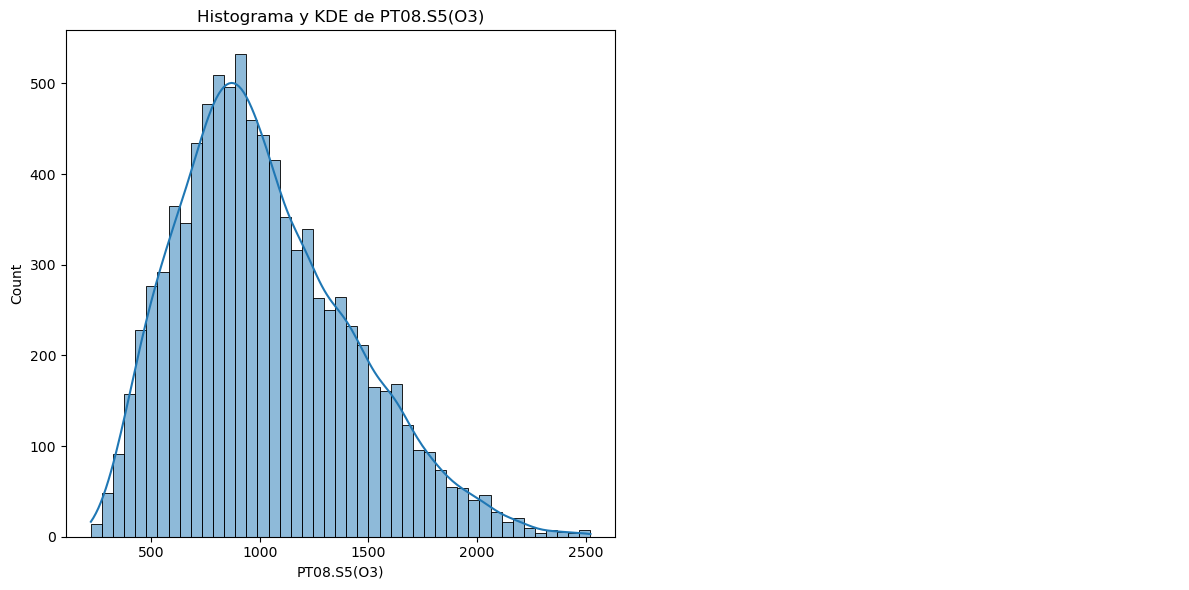

In [85]:
plot_histo_den(df,['PT08.S5(O3)'])

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [86]:
corr_matrix = train_set.corr()
corr_matrix.round(2)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.00,0.12,0.13,0.08,0.08,0.54,-0.09,0.68,-0.05,0.13,-0.13,-0.02,-0.18
PT08.S1(CO),0.12,1.00,0.24,0.88,0.89,0.57,-0.77,0.31,0.68,0.90,0.04,0.12,0.13
NMHC(GT),0.13,0.24,1.00,0.13,0.13,0.00,0.05,0.11,0.21,0.11,-0.07,-0.02,-0.13
C6H6(GT),0.08,0.88,0.13,1.00,0.98,0.54,-0.73,0.26,0.76,0.86,0.19,-0.05,0.17
PT08.S2(NMHC),0.08,0.89,0.13,0.98,1.00,0.54,-0.80,0.28,0.78,0.88,0.24,-0.08,0.19
NOx(GT),0.54,0.57,0.00,0.54,0.54,1.00,-0.50,0.82,0.15,0.62,-0.24,0.12,-0.20
PT08.S3(NOx),-0.09,-0.77,0.05,-0.73,-0.80,-0.50,1.00,-0.29,-0.54,-0.79,-0.14,-0.06,-0.23
NO2(GT),0.68,0.31,0.11,0.26,0.28,0.82,-0.29,1.00,0.02,0.34,-0.14,-0.08,-0.25
PT08.S4(NO2),-0.05,0.68,0.21,0.76,0.78,0.15,-0.54,0.02,1.00,0.59,0.56,-0.03,0.63
PT08.S5(O3),0.13,0.90,0.11,0.86,0.88,0.62,-0.79,0.34,0.59,1.00,-0.03,0.13,0.07


In [87]:
corr_matrix.loc[abs(corr_matrix['PT08.S5(O3)']) > 0.30 ]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
PT08.S1(CO),0.122506,1.000000,0.243351,0.884962,0.893618,0.567169,-0.771052,0.312481,0.679732,0.901005,0.044293,0.117609,0.131040
C6H6(GT),0.075437,0.884962,0.132976,1.000000,0.981825,0.538124,-0.733903,0.264477,0.764999,0.864269,0.193377,-0.053293,0.167025
PT08.S2(NMHC),0.083927,0.893618,0.129683,0.981825,1.000000,0.535406,-0.795214,0.284718,0.776315,0.879959,0.236493,-0.083230,0.185433
NOx(GT),0.537019,0.567169,0.000752,0.538124,0.535406,1.000000,-0.504951,0.821307,0.145186,0.623100,-0.244188,0.122632,-0.203319
PT08.S3(NOx),-0.088243,-0.771052,0.053649,-0.733903,-0.795214,-0.504951,1.000000,-0.289655,-0.537843,-0.794185,-0.144771,-0.057839,-0.230914
NO2(GT),0.676250,0.312481,0.105388,0.264477,0.284718,0.821307,-0.289655,1.000000,0.022972,0.337581,-0.139848,-0.077195,-0.250775
PT08.S4(NO2),-0.054931,0.679732,0.207487,0.764999,0.776315,0.145186,-0.537843,0.022972,1.000000,0.590688,0.559257,-0.029198,0.629302
PT08.S5(O3),0.128110,0.901005,0.110077,0.864269,0.879959,0.623100,-0.794185,0.337581,0.590688,1.000000,-0.032899,0.133955,0.069113


In [88]:
abs(corr_matrix['PT08.S5(O3)'].sort_values(ascending = False)).round(2)

PT08.S5(O3)      1.00
PT08.S1(CO)      0.90
PT08.S2(NMHC)    0.88
C6H6(GT)         0.86
NOx(GT)          0.62
PT08.S4(NO2)     0.59
NO2(GT)          0.34
RH               0.13
CO(GT)           0.13
NMHC(GT)         0.11
AH               0.07
T                0.03
PT08.S3(NOx)     0.79
Name: PT08.S5(O3), dtype: float64

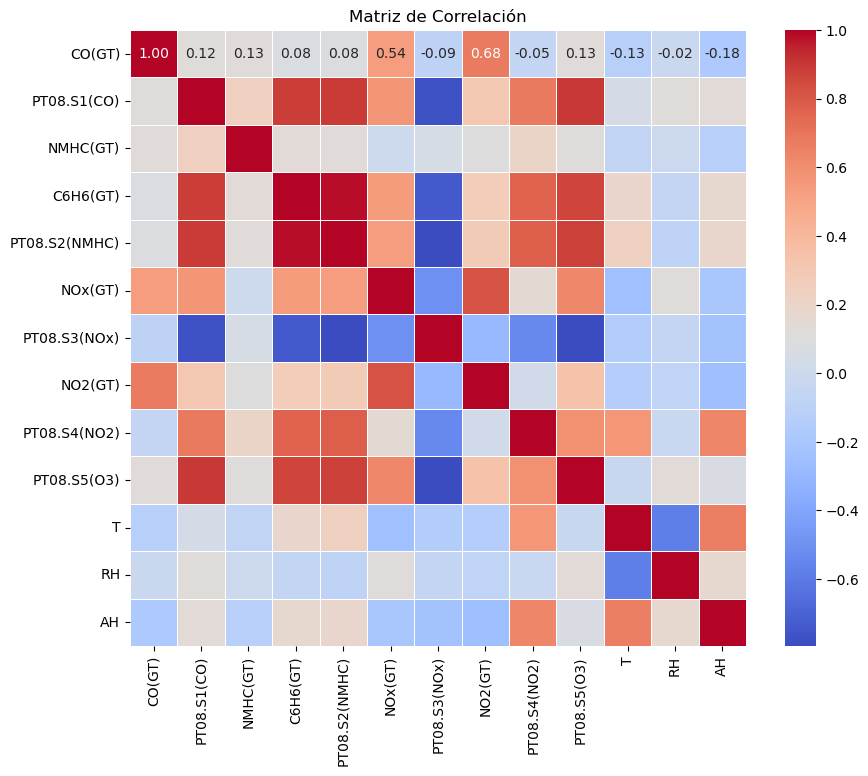

In [89]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            cbar=True, square=True, linewidths=.5) 

plt.title('Matriz de Correlación')
plt.xticks()
plt.yticks()

plt.show()

In [90]:
target = 'PT08.S5(O3)'

# Inicializar una lista para almacenar los pares de variables correlacionadas
high_corr_pairs = []

# Iterar sobre la matriz de correlación para encontrar los pares con |correlación| > 0.69
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.69:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], round(corr_matrix.iloc[i, j], 2)))

# Mostrar los pares de variables altamente correlacionadas
print("Pares de variables con correlación > 69%:")
for pair in high_corr_pairs:
    print(pair)
print('*'*25)
print()

# Seleccionar una variable de cada par según la mayor correlación, evitando la variable objetivo 'PT08.S5(O3)'
selected_variables = set()

for var1, var2, corr in high_corr_pairs:
    if var1 != target and var2 != target:  # Evitar incluir la variable objetivo
        selected_variables.add(var1)
        selected_variables.add(var2)

# Variables finales seleccionadas
print("Variables seleccionadas para el modelo:")
print(selected_variables)
print('*'*25)
print()

# Eliminar las variables no seleccionadas del conjunto de datos
variables_to_drop = set(corr_matrix.columns) - selected_variables
data_reduced = corr_matrix.drop(columns=variables_to_drop)

# Verificar las nuevas columnas
print(data_reduced.head())
print('*'*25)
print(data_reduced.columns.tolist())

Pares de variables con correlación > 69%:
('C6H6(GT)', 'PT08.S1(CO)', 0.88)
('PT08.S2(NMHC)', 'PT08.S1(CO)', 0.89)
('PT08.S2(NMHC)', 'C6H6(GT)', 0.98)
('PT08.S3(NOx)', 'PT08.S1(CO)', -0.77)
('PT08.S3(NOx)', 'C6H6(GT)', -0.73)
('PT08.S3(NOx)', 'PT08.S2(NMHC)', -0.8)
('NO2(GT)', 'NOx(GT)', 0.82)
('PT08.S4(NO2)', 'C6H6(GT)', 0.76)
('PT08.S4(NO2)', 'PT08.S2(NMHC)', 0.78)
('PT08.S5(O3)', 'PT08.S1(CO)', 0.9)
('PT08.S5(O3)', 'C6H6(GT)', 0.86)
('PT08.S5(O3)', 'PT08.S2(NMHC)', 0.88)
('PT08.S5(O3)', 'PT08.S3(NOx)', -0.79)
*************************

Variables seleccionadas para el modelo:
{'C6H6(GT)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S1(CO)', 'PT08.S3(NOx)', 'PT08.S2(NMHC)', 'NOx(GT)'}
*************************

               PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
CO(GT)            0.122506  0.075437       0.083927  0.537019     -0.088243   
PT08.S1(CO)       1.000000  0.884962       0.893618  0.567169     -0.771052   
NMHC(GT)          0.243351  0.132976       0.129683 

In [91]:
features_corr = data_reduced.columns.tolist()

(7, 2)


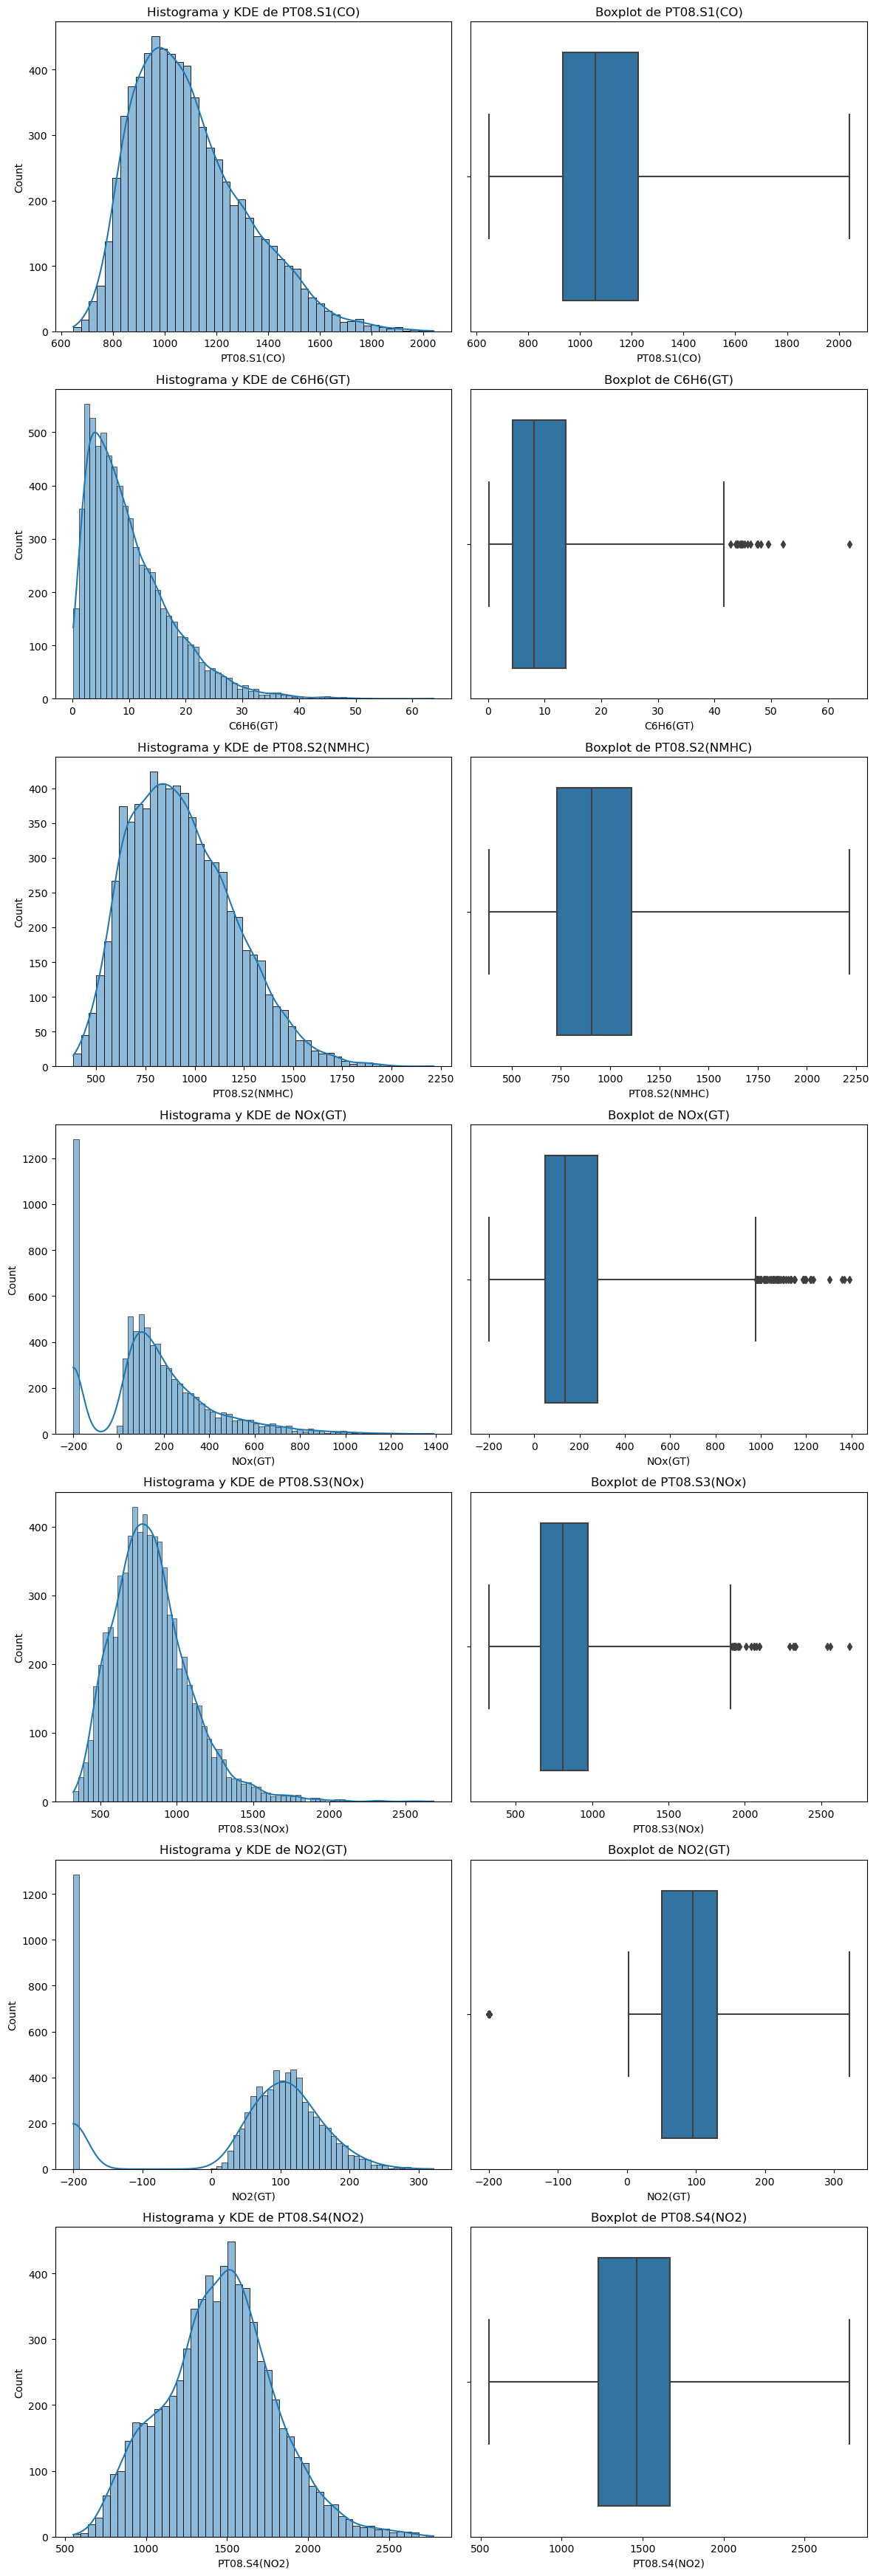

In [92]:
plot_combined_graphs(train_set,features_corr, whisker_width=3)

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [93]:
features_corr

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)']

- Regresión lineal
- RandomForestRegressor
- XGBoost
- LightGBM

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [94]:
train_set.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [102]:
from sklearn.preprocessing import PowerTransformer

# Definir características cuadradas y características no cuadradas
features_sqr = ['C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
features_scaler = list(set(features_corr) - set(features_sqr))

# Inicializar PowerTransformer con el método Yeo-Johnson
yeo_johnson_scaler = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()

# Aplicar la transformación Yeo-Johnson a las características cuadradas
for col in features_sqr:
    # Aplicar la transformación Yeo-Johnson
    train_set[f'yeo_{col}'] = yeo_johnson_scaler.fit_transform(train_set[[col]])
    test_set[f'yeo_{col}'] = yeo_johnson_scaler.transform(test_set[[col]])

# Escalar las características que no son cuadradas
for col in features_scaler:
    train_set[col] = scaler.fit_transform(train_set[[col]])
    test_set[col] = scaler.transform(test_set[[col]])

In [96]:
train_set.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'yeo_C6H6(GT)', 'yeo_NOx(GT)', 'yeo_NO2(GT)'],
      dtype='object')

In [103]:
train_set.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,yeo_C6H6(GT),yeo_NOx(GT),yeo_NO2(GT)
count,7192.000000,7.192000e+03,7192.000000,7192.000000,7.192000e+03,7192.000000,7.192000e+03,7192.000000,7.192000e+03,7192.000000,7192.000000,7192.000000,7192.000000,7.192000e+03,7.192000e+03,7.192000e+03
mean,-35.402183,-1.383148e-17,-160.296162,9.996265,1.975925e-17,162.499027,-2.568703e-17,55.716838,1.728935e-17,1017.120643,18.347794,49.253558,1.027951,-4.386554e-16,-8.891664e-18,-8.397682e-17
std,78.598763,1.000070e+00,137.760344,7.413889,1.000070e+00,251.498158,1.000070e+00,126.820691,1.000070e+00,397.817754,8.827794,17.260384,0.403272,1.000070e+00,1.000070e+00,1.000070e+00
min,-200.000000,-2.069754e+00,-200.000000,0.149048,-2.074766e+00,-200.000000,-1.998573e+00,-200.000000,-2.622986e+00,221.000000,-1.900000,9.175000,0.184679,-2.626523e+00,-1.479862e+00,-1.661423e+00
25%,0.600000,-7.528246e-01,-200.000000,4.372234,-7.690956e-01,47.000000,-6.859705e-01,51.000000,-6.606481e-01,725.187500,11.825000,35.800001,0.738636,-7.381093e-01,-4.375133e-01,-4.952183e-01
50%,1.400000,-1.726391e-01,-200.000000,8.144817,-1.149694e-01,138.000000,-1.186594e-01,95.000000,2.347486e-02,954.375000,17.775000,49.575000,0.997302,1.070582e-02,-7.935660e-02,1.001622e-01
75%,2.500000,5.940347e-01,-200.000000,13.806061,6.555710e-01,280.000000,5.240997e-01,131.000000,6.217421e-01,1268.062500,24.406250,62.574999,1.313524,7.374088e-01,4.752059e-01,6.263793e-01
max,11.500000,4.342217e+00,1189.000000,63.741476,4.800247e+00,1389.000000,7.135475e+00,321.600000,3.835976e+00,2522.250000,44.600000,88.725000,2.176616,3.283208e+00,4.753528e+00,3.757880e+00


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [122]:
columnas_eliminar = ['CO(GT)','NMHC(GT)','C6H6(GT)','NOx(GT)','NO2(GT)','PT08.S5(O3)','T','RH','AH']

X_train = train_set.drop(columns=columnas_eliminar)
y_train = train_set['PT08.S5(O3)']
X_test = test_set.drop(columns=columnas_eliminar)
y_test = test_set['PT08.S5(O3)']

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

- Regresión lineal
- RandomForestRegressor
- XGBoost
- LightGBM

In [99]:
reg_ln = LinearRegression()
rf = RandomForestRegressor(max_depth=4,random_state=42)
xgb = XGBRFRegressor(max_depth = 4, random_state = 42)



### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [104]:
X_train.isna().sum()

PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
yeo_C6H6(GT)     0
yeo_NOx(GT)      0
yeo_NO2(GT)      0
dtype: int64

In [119]:
model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBoost']
model_set = [reg_ln, rf, xgb]

# Crear un diccionario para almacenar las métricas de validación cruzada
metricas_cv = {}

# Lista para almacenar los valores 
valores = []

# Realizar validación cruzada para cada modelo
for nombre, modelo in zip(model_names, model_set):
    # Calcular las métricas de validación cruzada 
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        
    # Almacenar el resultado
    metricas_cv[nombre] = -scores
    valores.append(np.mean(scores))

# Encontrar el modelo con la mayor métrica
ganador = model_names[np.argmax(valores)]  # Usamos model_names para identificar el modelo ganador

# Imprimir los resultados
print("Resultados de la validación cruzada:")
for nombre, scores in metricas_cv.items():
    # Convertir neg_root_mean_squared_error a RMSE positivo
    rmse_scores = np.sqrt(scores)
    print(f"{nombre}: RMSE = {np.mean(rmse_scores):.3f}")
print('*'*25)
print(f"\nEl ganador es: {ganador}")

Resultados de la validación cruzada:
LinearRegression: RMSE = 12.023
RandomForestRegressor: RMSE = 12.130
XGBoost: RMSE = 12.085
*************************

El ganador es: LinearRegression


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [114]:
elastic_net_model = ElasticNet()
params_grid = {
    'l1_ratio': [0.5, 1, 2, 4, 8],
    'alpha': [1, 2, 4, 8, 16],
    'max_iter': [1000, 10000, 50000]
}

reg_ln_grid = GridSearchCV(
    estimator=elastic_net_model,
    param_grid=params_grid,
    scoring='neg_root_mean_squared_error',  
    cv=5  
)


reg_ln_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1, 2, 4, 8, 16],
                         'l1_ratio': [0.5, 1, 2, 4, 8],
                         'max_iter': [1000, 10000, 50000]},
             scoring='neg_root_mean_squared_error')

In [115]:
print(reg_ln_grid.best_score_)
print(reg_ln_grid.best_params_)

-144.66648147767035
{'alpha': 1, 'l1_ratio': 1, 'max_iter': 1000}


In [116]:
# Después de ajustar GridSearchCV
best_score = -reg_ln_grid.best_score_  # Convierte el puntaje negativo a positivo
print("Mejor RMSE en conjunto de entrenamiento:", np.sqrt(best_score))

Mejor RMSE en conjunto de entrenamiento: 12.027738003368311


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [126]:
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test,reg_ln_grid.predict(X_test)))
RMSE_test

145.85738819316518

### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [124]:
predictions = reg_ln_grid.predict(X_test)
predictions

array([1015.87448409, 1901.740267  , 1024.77049596, ...,  900.51669101,
       1293.99420654,  644.99097882])

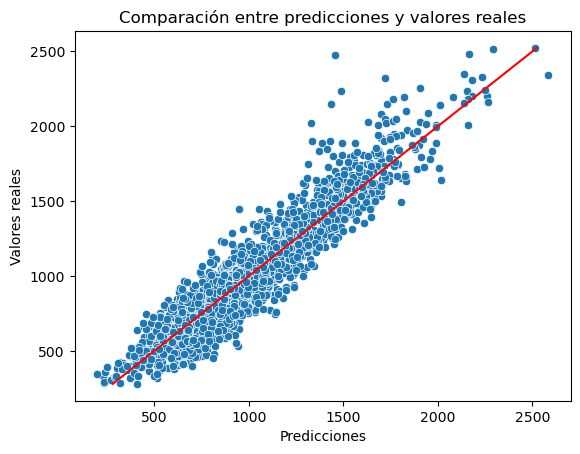

In [123]:
sns.scatterplot(x=predictions,y=y_test);

plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'red')

# Etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Comparación entre predicciones y valores reales')

# Mostrar el gráfico
plt.show()

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.

In [127]:
from joblib import dump

# Guardar el modelo en disco
dump(reg_ln_grid, './models/o3_pred')

['./models/o3_pred']